# Classifying Speech to Emotion using the RAVDESS dataset
###### Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

# Import Libraries

In [41]:
import pandas as pd
import numpy as np
import os
import random
import sys
import glob 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from mlxtend.classifier import StackingClassifier
import lightgbm as lgb
import xgboost as xgb
import optuna
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Functions

## Read in, Extract Features, and Label Data

In [2]:
def extract_feature(file_name):
    """Function Extracts Features from WAV file"""
    X, sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    tonnetz=np.mean(librosa.feature.tonnetz(y=X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, tonnetz))
    return result

#### List of Emotions and Function to Append Gender

In [3]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

def gender(g):
    """Returns Gender Label"""
    if int(g[0:2]) % 2 == 0:
        return 'female'
    else:
        return 'male'

In [4]:
def load_data(test_size=0.2):
    """Loads Data from directory containing WAV files."""
    x,y=[],[]
    for file in tqdm(glob.glob("data_w_song\\Actor_*\\*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] + '_' + gender(file_name.split("-")[-1])
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

## Split Data

In [45]:
X_train, X_test, y_train, y_test = load_data()

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [13:12<00:00,  3.09it/s]


In [46]:
print((X_train.shape[0], X_test.shape[0]))

(1961, 491)


In [47]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 186


## Scale Data

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Parameter Lists

In [49]:
lgb_params = {'num_leaves': 105, 
              'max_depth': 23, 
              'n_estimators': 3550, 
              'subsample_for_bin': 447914, 
              'min_data_in_leaf': 347, 
              'reg_alpha': 9.275853508763788, 
              'colsample_bytree': 0.19712313810660564, 
              'learning_rate': 0.8566650751800695, 
              'boosting_type': 'dart'}

In [50]:
rf_params = {'criterion': 'entropy', 
             'max_depth': 11, 
             'n_estimators': 24700, 
             'min_samples_leaf': 4, 
             'min_samples_split': 2, 
             'max_leaf_nodes': 239, 
             'random_state': 22}


In [51]:
xgb_params = {'booster': 'gbtree', 
              'lambda': 2.9195035696792674e-08, 
              'alpha': 4.5911516607293166e-05, 
              'max_depth': 5, 
              'eta': 0.0001446134158236531, 
              'gamma': 0.0014351654555313396, 
              'grow_policy': 'lossguide'}

In [52]:
dt_params = {'criterion': 'entropy', 
             'max_depth': 67, 
             'min_samples_leaf': 2, 
             'min_samples_split': 24, 
             'max_leaf_nodes': 114}
# acc 0.46

In [53]:
mlp_params = {'activation': 'relu', 
              'solver': 'lbfgs', 
              'hidden_layer_sizes': 975, 
              'alpha': 0.5659121380297304, 
              'batch_size': 186, 
              'learning_rate': 'adaptive',
              'max_iter':1000}

In [54]:
knn_params = {'weights': 'uniform', 
              'n_neighbors': 28}

In [55]:
lr_params = {'multi_class':'multinomial',
             'class_weight': None, 
             'solver': 'saga',
             'max_iter':10000}

### Models and Labels Lists

In [56]:
models = {'dt':DecisionTreeClassifier(**dt_params),
          'rf':RandomForestClassifier(**rf_params), 
          'lgb':lgb.LGBMClassifier(**lgb_params), 
          'xgb':xgb.XGBClassifier(**xgb_params),
          'mlp':MLPClassifier(**mlp_params), 
          'kn':KNeighborsClassifier(**knn_params), 
          'lr':LogisticRegression(**lr_params)}

model_abrv = {'dt':'Decision Tree Classifier', 
              'rf':'Random Forest Classifier', 
              'lgb':'LGBM Classifier', 
              'xgb':'XGB Classifier', 
              'mlp':'MLP Classifier',
              'kn':'K-Nearest Neighbors', 
              'lr':'Logistic Regression', 
              'v':'Voting Classifier: XGB, MLP', 
              'v2':'Voting Classifier 2: KNN, XGB, MLP', 
              'v3':'Voting Classifier 3: XGB, MLP, RF, LR', 
              'v4':'Voting Classifier 4: LGB, RF, LR'}

Models List Needs to be Created Before these Parameter Lists

In [57]:
v_params = {'estimators':[('mlp', models['mlp']), 
                          ('xgb', models['xgb'])], 
            'voting':'soft'}

In [58]:
v2_params = {'estimators':[('kn', models['kn']), 
                           ('xgb', models['xgb']), 
                           ('mlp', models['mlp'])], 
             'voting':'soft'}

In [59]:
v3_params = {'estimators':[('xgb', models['xgb']),
                           ('mlp', models['mlp']),
                           ('rf', models['rf']), 
                           ('lr', models['lr'])], 
             'voting':'soft'}

In [60]:
v4_params = {'estimators':[('rf', models['rf']), 
                           ('lgb', models['lgb']), 
                           ('lr', models['lr'])], 
             'voting':'soft'}

Add Voting Classifiers to Models List

In [61]:
models['v'] = VotingClassifier(**v_params)
models['v2'] = VotingClassifier(**v2_params)
models['v3'] = VotingClassifier(**v3_params)
models['v4'] = VotingClassifier(**v4_params)

### Modeling and Statistics Functions

In [80]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

In [95]:
def model(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    """Trains models and outputs score metrics. Has options for saving model, 
    printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
        clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
              np.mean(cross_val_score(clf_model, np.concatenate((X_train, X_test)), y_train + y_test, cv=5, scoring='accuracy')))
    if save == True:
        return clf_model

## Modeling

In [64]:
for key in models.keys():
    model(key, print_stat=False, cv=True)

Decision Tree Classifier CV Accuracy: 0.4575049537621717
Random Forest Classifier CV Accuracy: 0.6630662015022288
LGBM Classifier CV Accuracy: 0.5986577331713322
XGB Classifier CV Accuracy: 0.701108368727166
MLP Classifier CV Accuracy: 0.7793660999255968
K-Nearest Neighbors CV Accuracy: 0.5137775227811192
Logistic Regression CV Accuracy: 0.6627948399892596
Voting Classifier: XGB, MLP CV Accuracy: 0.7936757122671529
Voting Classifier 2: KNN, XGB, MLP CV Accuracy: 0.7915854078284973
Voting Classifier 3: XGB, MLP, RF, LR CV Accuracy: 0.7765051573636369
Voting Classifier 4: LGB, RF, LR CV Accuracy: 0.700688391808707


Decision Tree Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.42      0.53      0.47        30
      angry_male       0.58      0.65      0.61        34
     calm_female       0.60      0.74      0.66        34
       calm_male       0.71      0.57      0.63        44
  disgust_female       0.26      0.30      0.28        20
    disgust_male       0.33      0.23      0.27        13
  fearful_female       0.49      0.42      0.45        40
    fearful_male       0.34      0.30      0.32        40
    happy_female       0.45      0.50      0.47        42
      happy_male       0.38      0.41      0.39        37
  neutral_female       0.88      0.54      0.67        13
    neutral_male       0.34      0.50      0.41        22
      sad_female       0.68      0.54      0.60        39
        sad_male       0.33      0.32      0.32        41
surprised_female       0.33      0.35      0.34        20
  surprised_male       0.39      

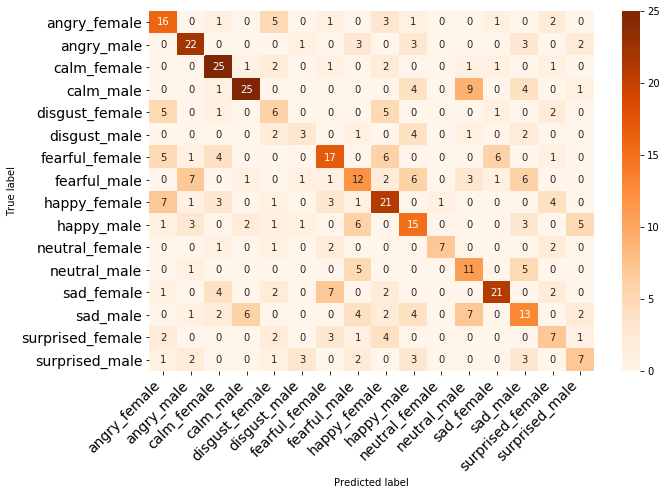

Decision Tree Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.81      0.79      0.80       154
      angry_male       0.83      0.87      0.85       158
     calm_female       0.82      0.88      0.85       150
       calm_male       0.82      0.66      0.73       148
  disgust_female       0.45      0.68      0.54        76
    disgust_male       0.89      0.41      0.56        83
  fearful_female       0.63      0.64      0.63       144
    fearful_male       0.66      0.66      0.66       152
    happy_female       0.72      0.73      0.72       142
      happy_male       0.65      0.73      0.68       155
  neutral_female       0.85      0.58      0.69        79
    neutral_male       0.59      0.78      0.67        74
      sad_female       0.76      0.72      0.74       145
        sad_male       0.69      0.73      0.71       151
surprised_female       0.68      0.72      0.70        76
  surprised_male       0.71     

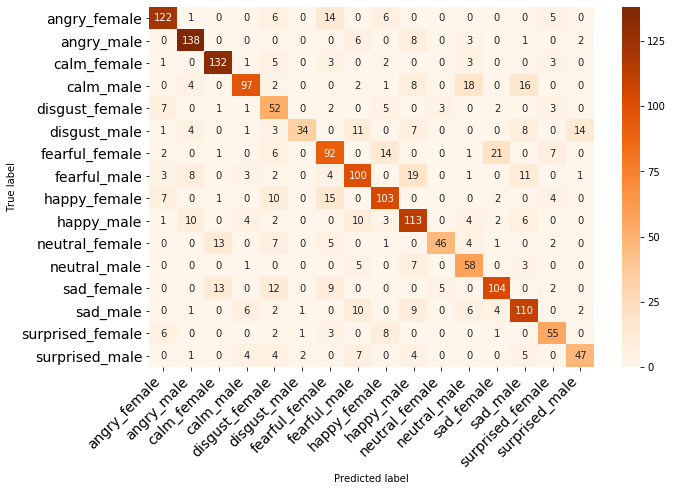

Random Forest Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.58      0.70      0.64        30
      angry_male       0.68      0.74      0.70        34
     calm_female       0.72      0.91      0.81        34
       calm_male       0.72      0.95      0.82        44
  disgust_female       0.68      0.65      0.67        20
    disgust_male       0.39      0.69      0.50        13
  fearful_female       0.68      0.62      0.65        40
    fearful_male       0.44      0.40      0.42        40
    happy_female       0.79      0.52      0.63        42
      happy_male       0.68      0.68      0.68        37
  neutral_female       0.85      0.85      0.85        13
    neutral_male       0.94      0.68      0.79        22
      sad_female       0.62      0.64      0.63        39
        sad_male       0.66      0.46      0.54        41
surprised_female       0.54      0.70      0.61        20
  surprised_male       0.85      

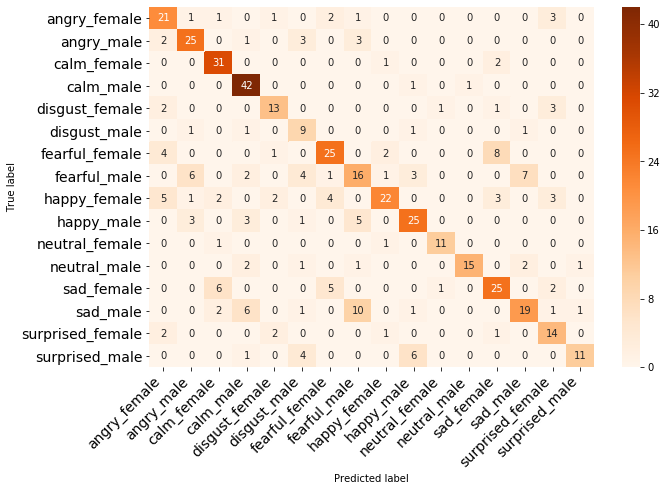

Random Forest Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.99      1.00      0.99       154
      angry_male       1.00      1.00      1.00       158
     calm_female       0.99      1.00      0.99       150
       calm_male       0.99      1.00      1.00       148
  disgust_female       1.00      0.97      0.99        76
    disgust_male       1.00      0.99      0.99        83
  fearful_female       0.99      0.99      0.99       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      0.99      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       0.99      0.99      0.99       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00     

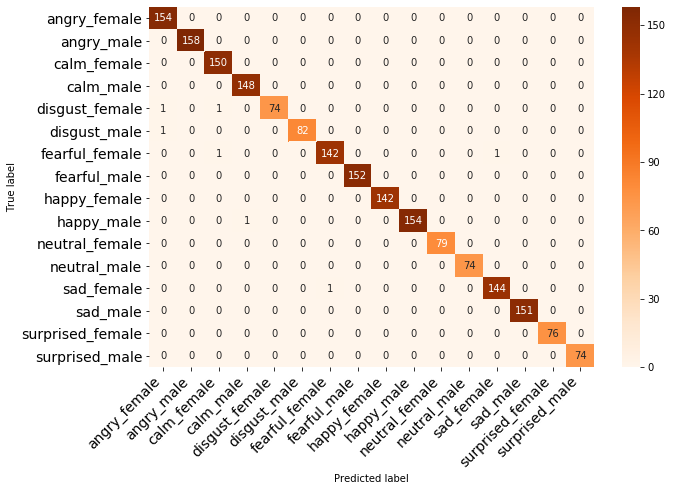

LGBM Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.56      0.73      0.64        30
      angry_male       0.58      0.74      0.65        34
     calm_female       0.67      0.88      0.76        34
       calm_male       0.62      0.70      0.66        44
  disgust_female       0.70      0.35      0.47        20
    disgust_male       0.27      0.46      0.34        13
  fearful_female       0.49      0.57      0.53        40
    fearful_male       0.42      0.42      0.42        40
    happy_female       0.74      0.60      0.66        42
      happy_male       0.62      0.54      0.58        37
  neutral_female       0.77      0.77      0.77        13
    neutral_male       0.82      0.64      0.72        22
      sad_female       0.69      0.56      0.62        39
        sad_male       0.50      0.44      0.47        41
surprised_female       0.59      0.65      0.62        20
  surprised_male       0.78      0.32     

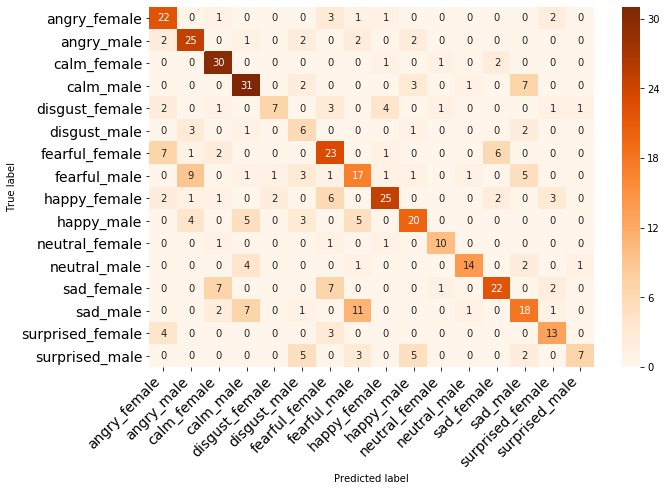

LGBM Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.89      0.94      0.91       154
      angry_male       0.89      0.94      0.91       158
     calm_female       0.85      0.97      0.91       150
       calm_male       0.77      0.90      0.83       148
  disgust_female       0.78      0.71      0.74        76
    disgust_male       0.76      0.75      0.75        83
  fearful_female       0.81      0.81      0.81       144
    fearful_male       0.85      0.82      0.83       152
    happy_female       0.93      0.90      0.91       142
      happy_male       0.87      0.86      0.87       155
  neutral_female       0.93      0.80      0.86        79
    neutral_male       0.89      0.73      0.80        74
      sad_female       0.81      0.85      0.83       145
        sad_male       0.82      0.83      0.83       151
surprised_female       0.88      0.79      0.83        76
  surprised_male       0.93      0.68    

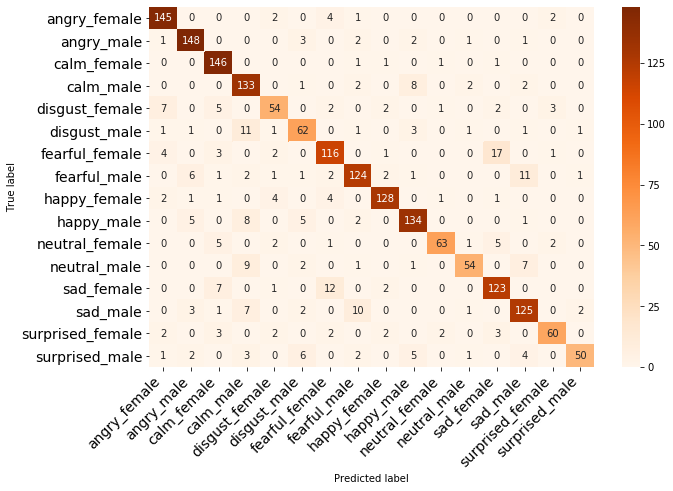

XGB Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.70      0.70      0.70        30
      angry_male       0.85      0.82      0.84        34
     calm_female       0.75      0.88      0.81        34
       calm_male       0.77      0.84      0.80        44
  disgust_female       0.63      0.60      0.62        20
    disgust_male       0.48      0.77      0.59        13
  fearful_female       0.64      0.70      0.67        40
    fearful_male       0.62      0.57      0.60        40
    happy_female       0.84      0.74      0.78        42
      happy_male       0.71      0.73      0.72        37
  neutral_female       0.67      0.77      0.71        13
    neutral_male       0.89      0.77      0.83        22
      sad_female       0.76      0.64      0.69        39
        sad_male       0.69      0.66      0.68        41
surprised_female       0.57      0.65      0.60        20
  surprised_male       0.93      0.64      

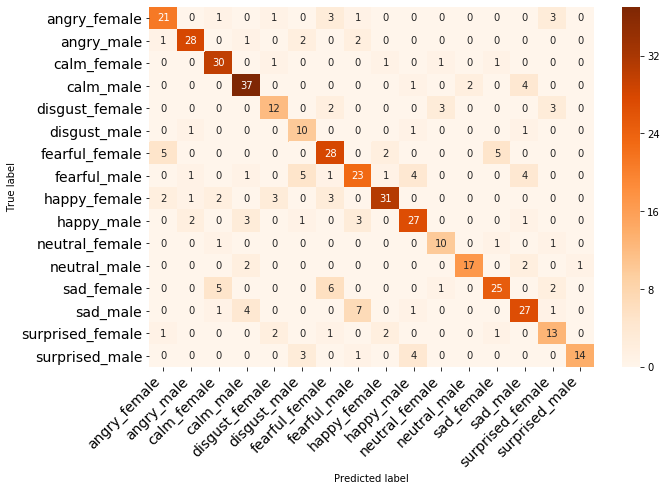

XGB Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00     

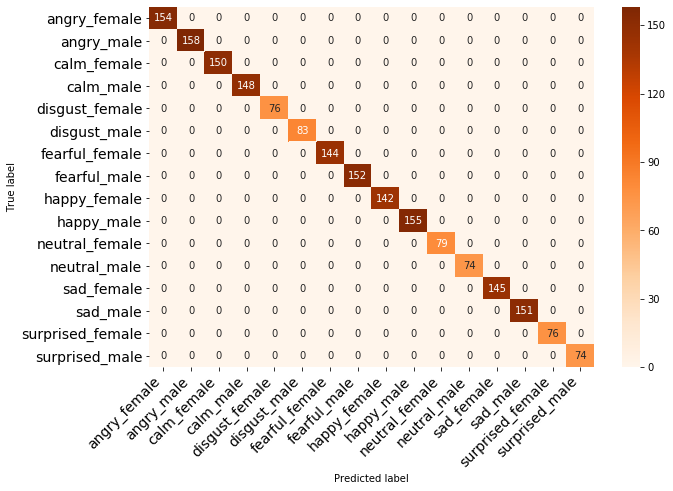

MLP Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.85      0.77      0.81        30
      angry_male       0.91      0.85      0.88        34
     calm_female       0.79      0.91      0.85        34
       calm_male       0.80      0.84      0.82        44
  disgust_female       0.87      0.65      0.74        20
    disgust_male       0.73      0.85      0.79        13
  fearful_female       0.78      0.78      0.78        40
    fearful_male       0.77      0.90      0.83        40
    happy_female       0.78      0.83      0.80        42
      happy_male       0.73      0.73      0.73        37
  neutral_female       0.61      0.85      0.71        13
    neutral_male       0.75      0.82      0.78        22
      sad_female       0.83      0.64      0.72        39
        sad_male       0.84      0.66      0.74        41
surprised_female       0.71      0.85      0.77        20
  surprised_male       0.85      0.77      

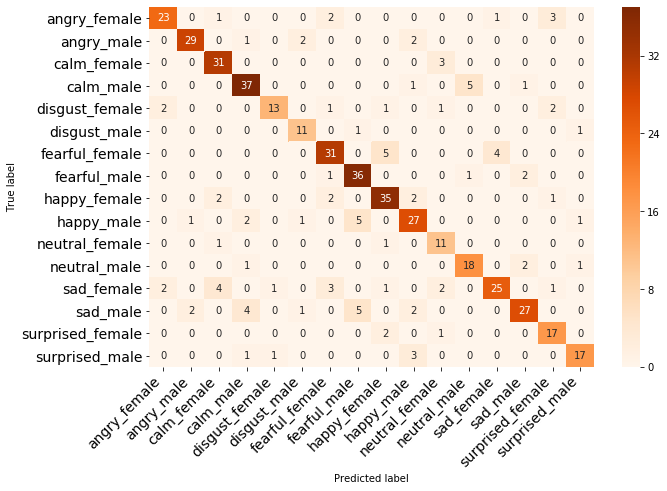

MLP Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00     

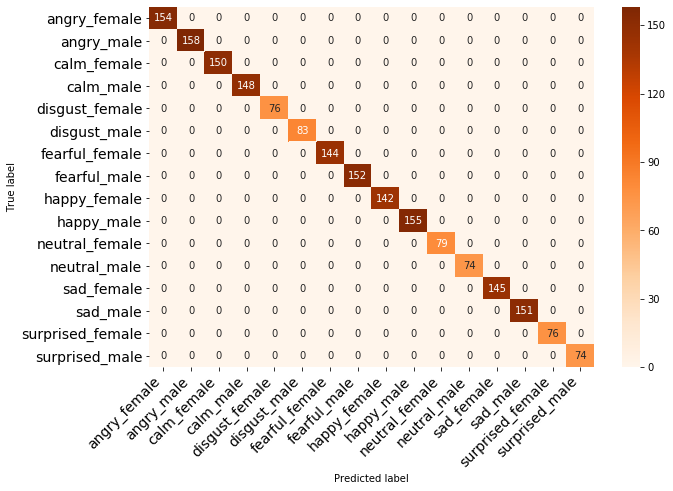

K-Nearest Neighbors

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.53      0.57      0.55        30
      angry_male       0.80      0.59      0.68        34
     calm_female       0.59      0.88      0.71        34
       calm_male       0.60      0.61      0.61        44
  disgust_female       0.44      0.60      0.51        20
    disgust_male       0.25      0.77      0.38        13
  fearful_female       0.39      0.38      0.38        40
    fearful_male       0.47      0.45      0.46        40
    happy_female       0.64      0.38      0.48        42
      happy_male       0.39      0.32      0.35        37
  neutral_female       0.73      0.62      0.67        13
    neutral_male       0.78      0.64      0.70        22
      sad_female       0.40      0.26      0.31        39
        sad_male       0.57      0.39      0.46        41
surprised_female       0.34      0.60      0.44        20
  surprised_male       0.45      0.45 

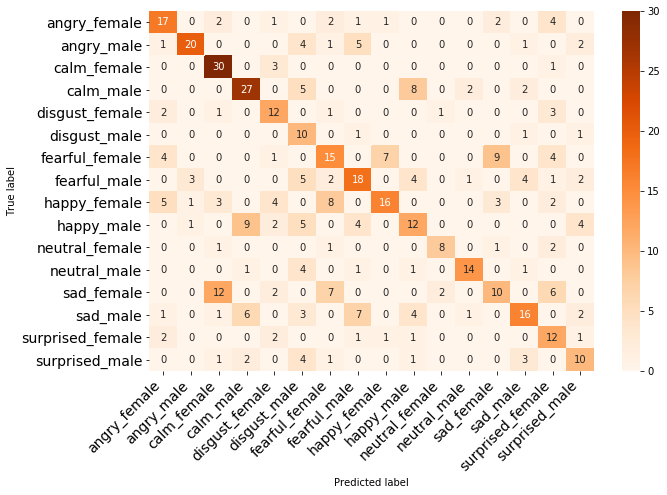

K-Nearest Neighbors

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.75      0.61      0.67       154
      angry_male       0.79      0.67      0.72       158
     calm_female       0.58      0.88      0.70       150
       calm_male       0.64      0.82      0.72       148
  disgust_female       0.45      0.53      0.48        76
    disgust_male       0.36      0.63      0.46        83
  fearful_female       0.62      0.53      0.57       144
    fearful_male       0.59      0.54      0.56       152
    happy_female       0.80      0.46      0.59       142
      happy_male       0.71      0.44      0.54       155
  neutral_female       0.68      0.34      0.45        79
    neutral_male       0.67      0.51      0.58        74
      sad_female       0.59      0.54      0.56       145
        sad_male       0.67      0.58      0.62       151
surprised_female       0.36      0.76      0.49        76
  surprised_male       0.43      0.53

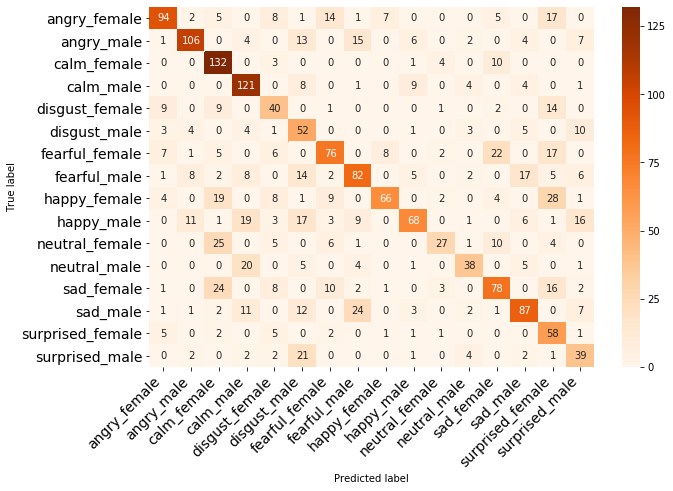

Gaussian Naive Bayes

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.65      0.57      0.61        30
      angry_male       0.58      0.41      0.48        34
     calm_female       0.46      0.35      0.40        34
       calm_male       0.24      0.20      0.22        44
  disgust_female       0.30      0.30      0.30        20
    disgust_male       0.36      0.31      0.33        13
  fearful_female       0.53      0.23      0.32        40
    fearful_male       0.50      0.15      0.23        40
    happy_female       0.37      0.24      0.29        42
      happy_male       0.31      0.27      0.29        37
  neutral_female       0.26      0.69      0.38        13
    neutral_male       0.15      0.82      0.26        22
      sad_female       0.21      0.21      0.21        39
        sad_male       0.20      0.20      0.20        41
surprised_female       0.22      0.10      0.14        20
  surprised_male       0.16      0.14

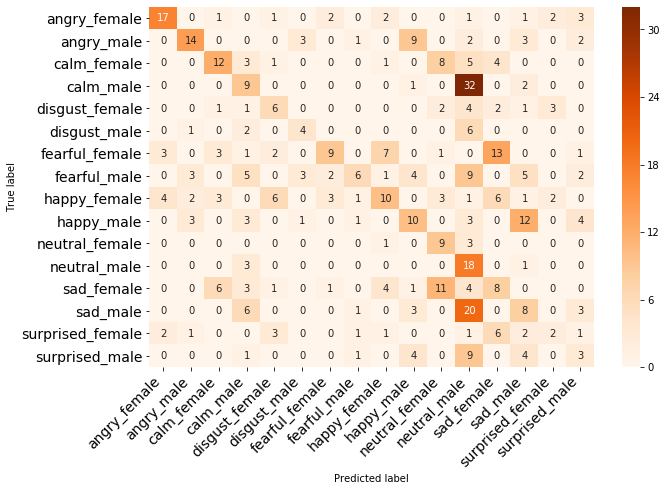

Gaussian Naive Bayes

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.70      0.35      0.47       154
      angry_male       0.81      0.47      0.60       158
     calm_female       0.53      0.51      0.52       150
       calm_male       0.35      0.39      0.37       148
  disgust_female       0.31      0.25      0.28        76
    disgust_male       0.32      0.23      0.27        83
  fearful_female       0.43      0.17      0.24       144
    fearful_male       0.26      0.12      0.16       152
    happy_female       0.38      0.33      0.35       142
      happy_male       0.39      0.32      0.35       155
  neutral_female       0.28      0.49      0.36        79
    neutral_male       0.15      0.93      0.25        74
      sad_female       0.27      0.23      0.25       145
        sad_male       0.19      0.18      0.18       151
surprised_female       0.42      0.20      0.27        76
  surprised_male       0.29      0.3

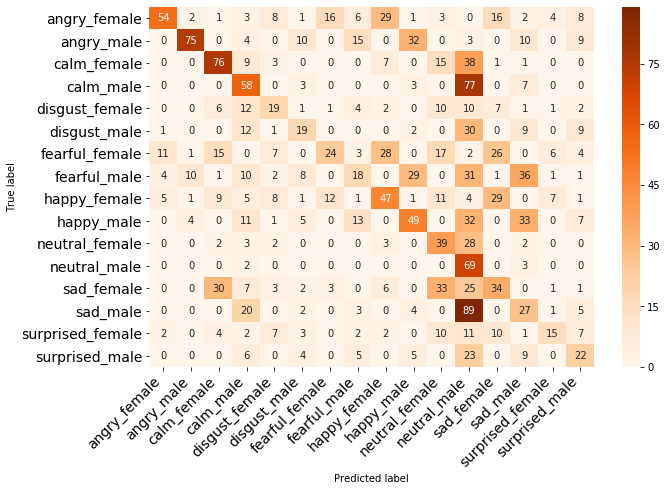

Logistic Regression

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.75      0.70      0.72        30
      angry_male       0.82      0.82      0.82        34
     calm_female       0.69      0.79      0.74        34
       calm_male       0.72      0.82      0.77        44
  disgust_female       0.53      0.45      0.49        20
    disgust_male       0.48      0.77      0.59        13
  fearful_female       0.59      0.55      0.57        40
    fearful_male       0.74      0.57      0.65        40
    happy_female       0.73      0.83      0.78        42
      happy_male       0.64      0.76      0.69        37
  neutral_female       0.69      0.85      0.76        13
    neutral_male       0.77      0.77      0.77        22
      sad_female       0.55      0.44      0.49        39
        sad_male       0.72      0.63      0.68        41
surprised_female       0.53      0.50      0.51        20
  surprised_male       0.78      0.64 

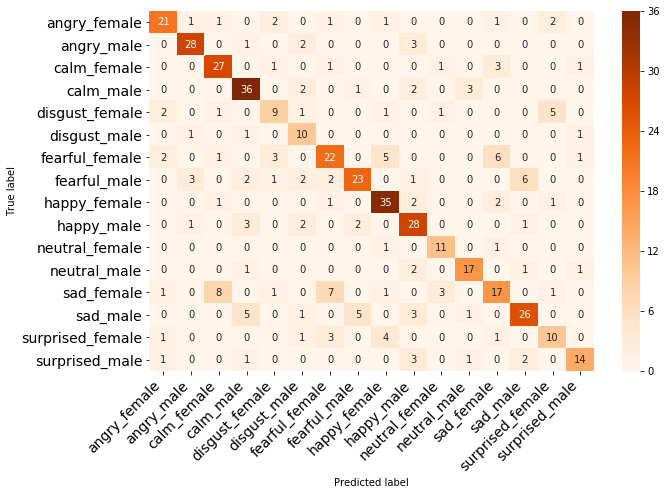

Logistic Regression

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.98      0.94      0.96       154
      angry_male       0.94      0.94      0.94       158
     calm_female       0.83      0.91      0.87       150
       calm_male       0.78      0.87      0.82       148
  disgust_female       0.74      0.83      0.78        76
    disgust_male       0.81      0.75      0.77        83
  fearful_female       0.89      0.81      0.84       144
    fearful_male       0.80      0.84      0.82       152
    happy_female       0.92      0.89      0.91       142
      happy_male       0.84      0.77      0.81       155
  neutral_female       0.85      0.76      0.80        79
    neutral_male       0.80      0.77      0.79        74
      sad_female       0.75      0.81      0.78       145
        sad_male       0.75      0.77      0.76       151
surprised_female       0.82      0.80      0.81        76
  surprised_male       0.81      0.74

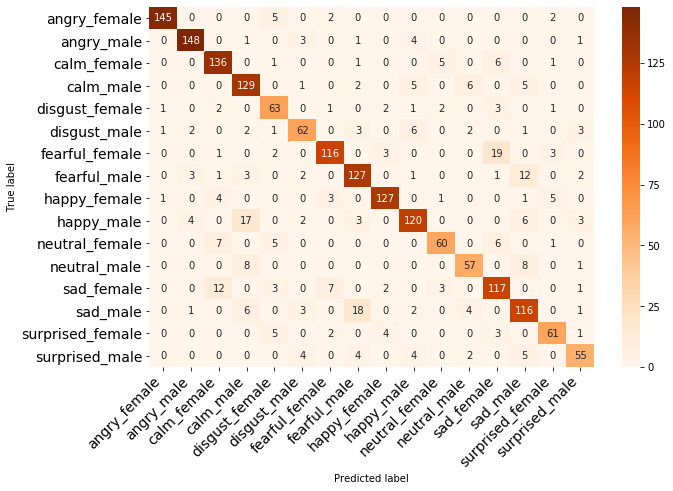

Voting Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.85      0.73      0.79        30
      angry_male       0.91      0.88      0.90        34
     calm_female       0.84      0.91      0.87        34
       calm_male       0.85      0.91      0.88        44
  disgust_female       0.88      0.75      0.81        20
    disgust_male       0.67      0.92      0.77        13
  fearful_female       0.77      0.82      0.80        40
    fearful_male       0.76      0.80      0.78        40
    happy_female       0.86      0.90      0.88        42
      happy_male       0.76      0.78      0.77        37
  neutral_female       0.69      0.85      0.76        13
    neutral_male       0.82      0.82      0.82        22
      sad_female       0.86      0.64      0.74        39
        sad_male       0.89      0.76      0.82        41
surprised_female       0.69      0.90      0.78        20
  surprised_male       0.94      0.77   

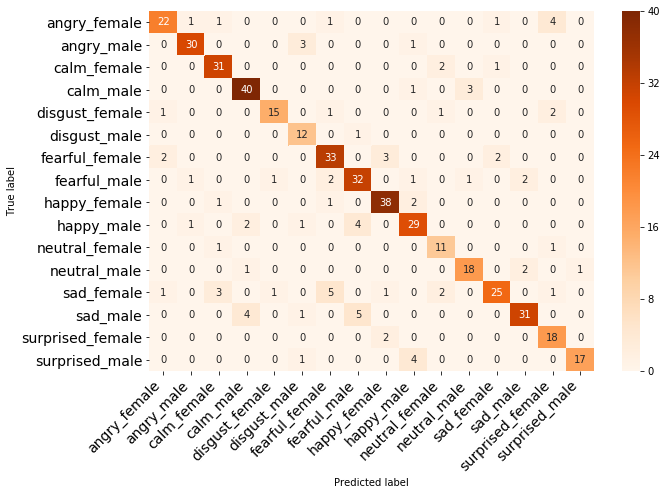

Voting Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00  

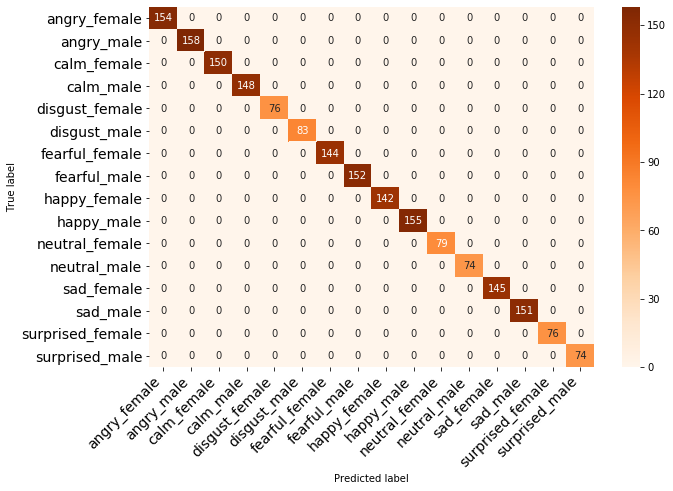

Voting Classifier 2

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.82      0.77      0.79        30
      angry_male       0.88      0.88      0.88        34
     calm_female       0.82      0.91      0.86        34
       calm_male       0.85      0.91      0.88        44
  disgust_female       0.89      0.80      0.84        20
    disgust_male       0.63      0.92      0.75        13
  fearful_female       0.77      0.82      0.80        40
    fearful_male       0.71      0.80      0.75        40
    happy_female       0.89      0.81      0.85        42
      happy_male       0.82      0.76      0.79        37
  neutral_female       0.69      0.85      0.76        13
    neutral_male       0.82      0.82      0.82        22
      sad_female       0.83      0.64      0.72        39
        sad_male       0.85      0.71      0.77        41
surprised_female       0.67      0.90      0.77        20
  surprised_male       0.94      0.77 

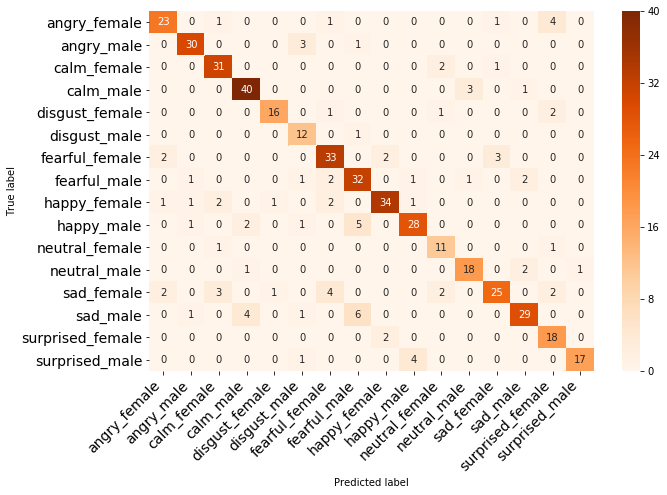

Voting Classifier 2

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00

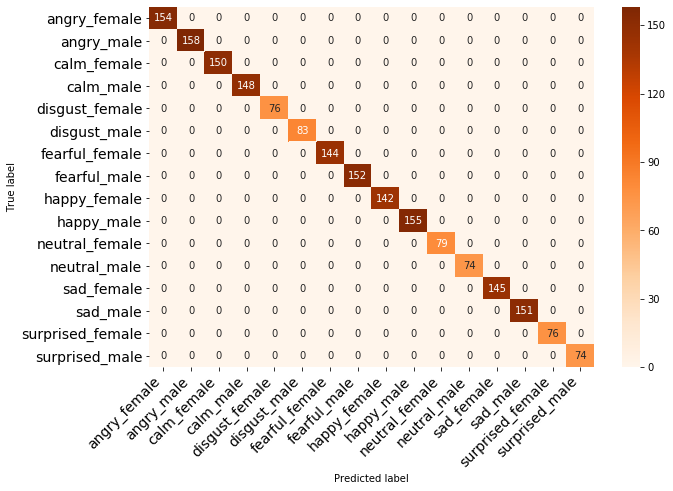

Voting Classifier 3

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.88      0.73      0.80        30
      angry_male       0.88      0.88      0.88        34
     calm_female       0.78      0.91      0.84        34
       calm_male       0.80      0.93      0.86        44
  disgust_female       0.76      0.65      0.70        20
    disgust_male       0.69      0.85      0.76        13
  fearful_female       0.73      0.80      0.76        40
    fearful_male       0.74      0.72      0.73        40
    happy_female       0.90      0.86      0.88        42
      happy_male       0.76      0.76      0.76        37
  neutral_female       0.67      0.92      0.77        13
    neutral_male       0.86      0.82      0.84        22
      sad_female       0.86      0.64      0.74        39
        sad_male       0.81      0.71      0.75        41
surprised_female       0.69      0.90      0.78        20
  surprised_male       0.89      0.73 

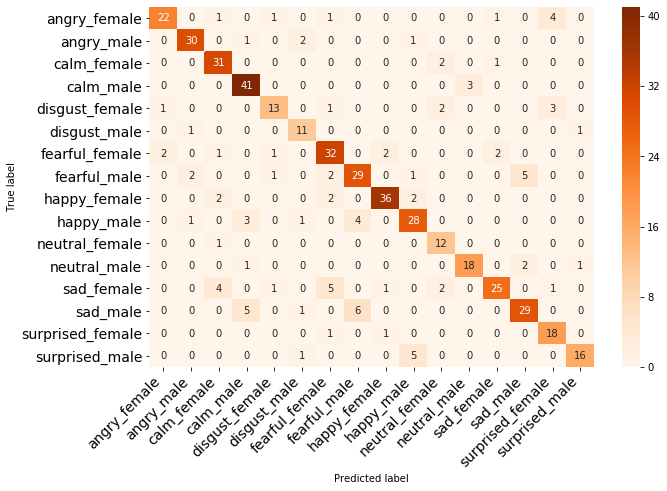

Voting Classifier 3

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00       154
      angry_male       1.00      1.00      1.00       158
     calm_female       1.00      1.00      1.00       150
       calm_male       1.00      1.00      1.00       148
  disgust_female       1.00      1.00      1.00        76
    disgust_male       1.00      1.00      1.00        83
  fearful_female       1.00      1.00      1.00       144
    fearful_male       1.00      1.00      1.00       152
    happy_female       1.00      1.00      1.00       142
      happy_male       1.00      1.00      1.00       155
  neutral_female       1.00      1.00      1.00        79
    neutral_male       1.00      1.00      1.00        74
      sad_female       1.00      1.00      1.00       145
        sad_male       1.00      1.00      1.00       151
surprised_female       1.00      1.00      1.00        76
  surprised_male       1.00      1.00

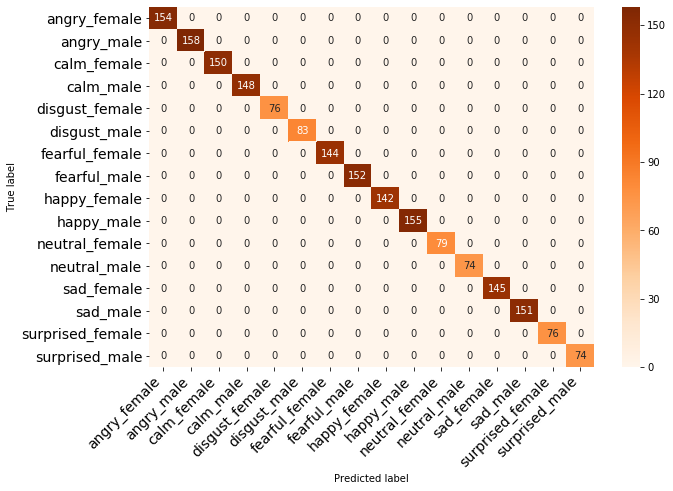

In [34]:
for key in models.keys():
    model(key, inc_train=True)

# Hyperparameter Tuning with Optuna

#### The hyperparameter tuning below will cause the notebook to run for a very long time

### LGBM

In [26]:
def objective_lgb(trial): 

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 20000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 100000, 500000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 100),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['goss','gbdt', 'rf', 'dart']),
        'objective': 'multiclass',
        'verbose': -1,
        'random_state':22,
        }
    
    X_train, X_valid, y_train, y_valid = load_data(test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = lgb.LGBMClassifier(**params, nthread = 4, n_jobs = -1) 
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=False, early_stopping_rounds=500)
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=6) 

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:28<00:00,  3.56it/s]
[I 2019-11-29 17:13:13,513] Finished trial#0 resulted in value: 0.5925701027971161. Current best value is 0.5925701027971161 with parameters: {'num_leaves': 64, 'max_depth': 2, 'n_estimators': 19515, 'subsample_for_bin': 302147, 'min_data_in_leaf': 240, 'reg_alpha': 25.432666628348088, 'colsample_bytree': 0.7079417485930666, 'learning_rate': 0.01321547484015692, 'boosting_type': 'goss'}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [10:54<00:00,  3.75it/s]
[I 2019-11-29 17:29:23,227] Finished trial#1 resulted in value: 0.21151167828243703. Current best value is 0.5925701027971161 with parameters: {'num_leaves': 64, 'max_depth': 2, 'n_estimators': 19515, 'subsample_for_bin': 302147, 'min_data_in_leaf': 240, 'reg_alpha': 25.432666628348088, 'colsample_bytree': 0.7079417485930666, 'learning_rate': 0.01321547484015692, 'bo

### Random Forest

In [28]:
def objective_rf(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'n_estimators': trial.suggest_int('n_estimators', 15000, 25000),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
  
    X_train, X_valid, y_train, y_valid = load_data(test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = RandomForestClassifier(**params, random_state = 22) 
    model.fit(X_train, y_train)
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=5) 

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [13:01<00:00,  3.14it/s]
[I 2019-11-29 21:15:43,826] Finished trial#0 resulted in value: 0.6630662015022288. Current best value is 0.6630662015022288 with parameters: {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 24700, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_leaf_nodes': 239}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [12:12<00:00,  3.35it/s]
[I 2019-11-29 23:24:17,797] Finished trial#1 resulted in value: 0.6272270027770113. Current best value is 0.6630662015022288 with parameters: {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 24700, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_leaf_nodes': 239}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [13:12<00:00,  3.10it/s]
[I 2019-11-30 01:10:36,773] Finished trial#2 resulted in value: 0.6227068133841804. 

### XGBoost

In [30]:
def objective_xgb(trial):

    param = {
        'silent': 1,
        'objective': 'multi:softmax',
        'num_class': 16,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    X_train, X_valid, y_train, y_valid = load_data(test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = xgb.XGBClassifier() 
    model.fit(X_train, y_train)
    
    model.set_params(**param)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [31]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=5) 

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:46<00:00,  3.47it/s]
[I 2019-11-30 03:21:20,843] Finished trial#0 resulted in value: 0.39392610400698347. Current best value is 0.39392610400698347 with parameters: {'booster': 'gblinear', 'lambda': 0.0014339168664241632, 'alpha': 6.610449087227416e-05}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:50<00:00,  3.45it/s]
[I 2019-11-30 03:33:57,488] Finished trial#1 resulted in value: 0.39392610400698347. Current best value is 0.39392610400698347 with parameters: {'booster': 'gblinear', 'lambda': 0.0014339168664241632, 'alpha': 6.610449087227416e-05}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:50<00:00,  3.45it/s]
[I 2019-11-30 03:50:15,251] Finished trial#2 resulted in value: 0.6998797731046958. Current best value is 0.6998797731046958 with parameters: {'booster': 'gbtree', 'lambda'

### MLP 

In [32]:
def objective_mlp(trial):

    params = {
        'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'hidden_layer_sizes':trial.suggest_int('hidden_layer_sizes', 100, 1500),
        'alpha': trial.suggest_uniform('alpha', 0.001, 0.99),
        'batch_size':trial.suggest_int('batch_size', 150, 300), 
        'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant', 'invscaling']),
        'max_iter': 1000
        }
  
    X_train, X_valid, y_train, y_valid = load_data(test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = MLPClassifier(**params, random_state = 22) 
    model.fit(X_train, y_train)
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp, n_trials=15)

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [12:01<00:00,  3.40it/s]
C:\Users\rocco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\rocco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\rocco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\rocco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\roc

### KNN

In [5]:
def objective_knn(trial):

    params = { 
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 200),
        }
  
    X_train, X_valid, y_train, y_valid = load_data()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = KNeighborsClassifier(**params) 
    model.fit(X_train, y_train)
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=10)

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:18<00:00,  3.62it/s]
[I 2019-11-30 11:18:50,707] Finished trial#0 resulted in value: 0.43405581305386426. Current best value is 0.43405581305386426 with parameters: {'weights': 'uniform', 'n_neighbors': 144}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [10:53<00:00,  3.75it/s]
[I 2019-11-30 11:29:47,225] Finished trial#1 resulted in value: 0.45188413793184196. Current best value is 0.45188413793184196 with parameters: {'weights': 'uniform', 'n_neighbors': 110}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:30<00:00,  3.55it/s]
[I 2019-11-30 11:41:20,274] Finished trial#2 resulted in value: 0.4861392970641479. Current best value is 0.4861392970641479 with parameters: {'weights': 'uniform', 'n_neighbors': 60}.
100%|██████████████████████████████████████████████████████████████████████████

### Decision Tree

In [7]:
def objective_dt(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
  
    X_train, X_valid, y_train, y_valid = load_data(test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = DecisionTreeClassifier(**params, random_state = 22) 
    model.fit(X_train, y_train)
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=5) 

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:41<00:00,  3.50it/s]
[I 2019-11-30 13:13:14,936] Finished trial#0 resulted in value: 0.4159553303316127. Current best value is 0.4159553303316127 with parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 18, 'max_leaf_nodes': 73}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:44<00:00,  3.48it/s]
[I 2019-11-30 13:25:02,187] Finished trial#1 resulted in value: 0.4376737278507375. Current best value is 0.4376737278507375 with parameters: {'criterion': 'gini', 'max_depth': 65, 'min_samples_leaf': 2, 'min_samples_split': 22, 'max_leaf_nodes': 158}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [11:55<00:00,  3.43it/s]
[I 2019-11-30 13:37:04,615] Finished trial#2 resulted in value: 0.4442685447323451. Current best value is 0.4442685447323451 with param

### Logistic Regression

In [10]:
def objective_lr(trial):

    params = { 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga', 'lbfgs']),
        'multi_class':'multinomial',
        'max_iter': 5000
        }
  
    X_train, X_valid, y_train, y_valid = load_data()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = LogisticRegression(**params, random_state = 22) 
    model.fit(X_train, y_train)
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, np.concatenate((X_train, X_valid)), y_train + y_valid, cv=5, scoring='accuracy'))

In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=10)

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [12:44<00:00,  3.21it/s]
[I 2019-11-30 20:39:07,986] Finished trial#0 resulted in value: 0.6611333701058411. Current best value is 0.6611333701058411 with parameters: {'class_weight': None, 'solver': 'lbfgs'}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [12:26<00:00,  3.28it/s]
[I 2019-11-30 20:51:41,295] Finished trial#1 resulted in value: 0.6557767240573507. Current best value is 0.6611333701058411 with parameters: {'class_weight': None, 'solver': 'lbfgs'}.
100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [12:36<00:00,  3.24it/s]
[I 2019-11-30 21:13:33,625] Finished trial#2 resulted in value: 0.657513250431213. Current best value is 0.6611333701058411 with parameters: {'class_weight': None, 'solver': 'lbfgs'}.
100%|██████████████████████████████████████████████████████████████████████████████| 2